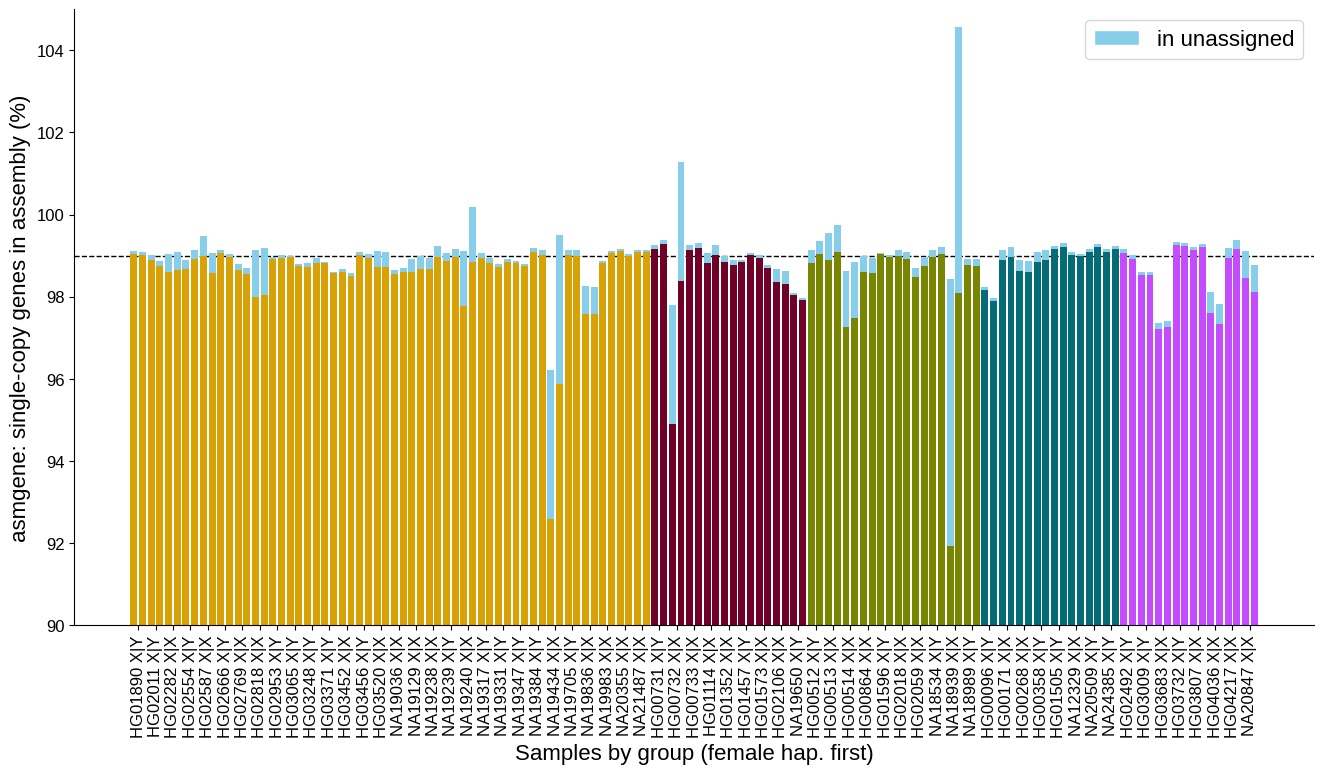

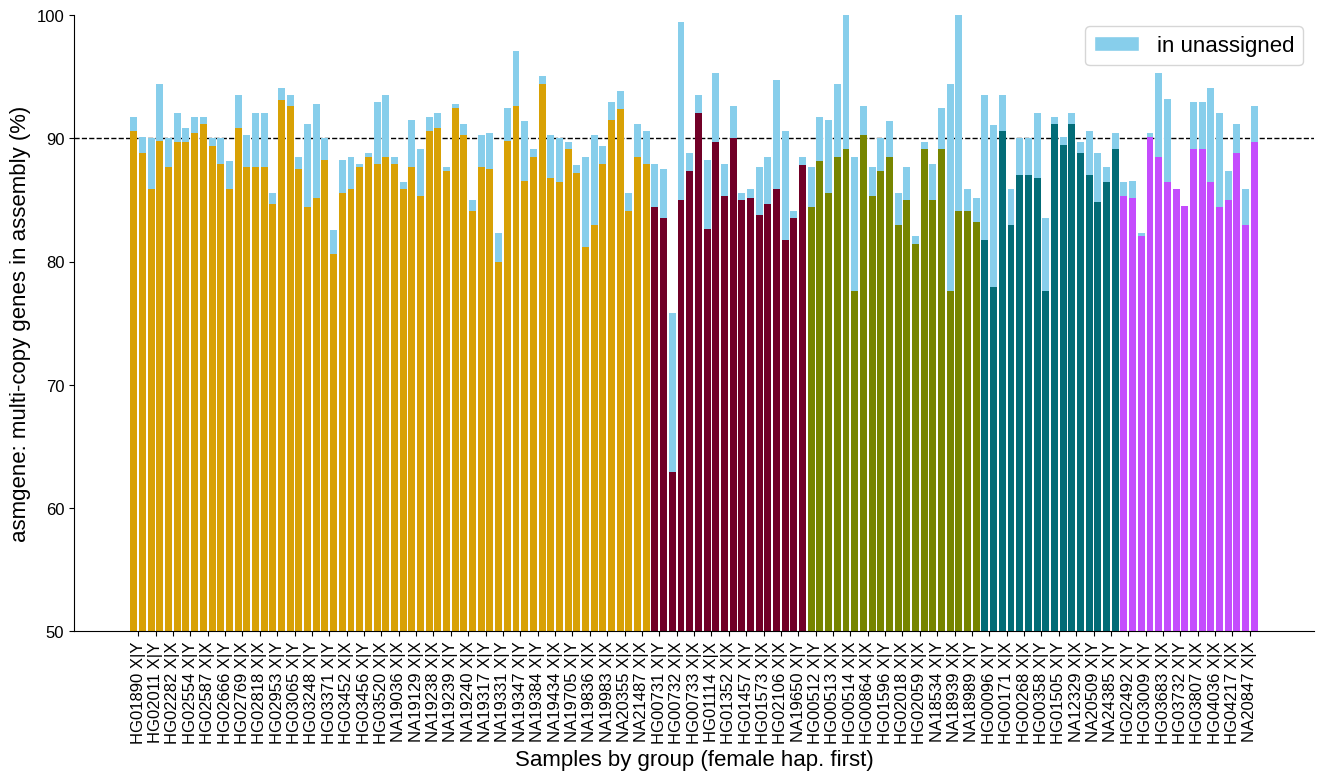

In [15]:
%run -n "../../00_project_config.ipynb"
%run -n "../../05_plot_config.ipynb"
%run -n "../../10_assm_stats.ipynb"

import pathlib as pl
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt


data_source = PROJECT_DATA_ROOT.joinpath(
    "2024_asmgene", "summary", "hgsvc3"
)


def get_karyotype(stats):
    
    get_entity = stats["entity"] == "reference_name"
    ref = stats.loc[get_entity, "statistic"].iloc[0]
    karyotype = ref.split(".")[-1]
    assert karyotype in ["male", "female", "any"]
    return karyotype


def read_asmgene_stat_summary(file_path):
    
    sample = file_path.name.split(".")[0]
    asm_unit = file_path.name.split(".")[2].split("-")[-1]
    df = pd.read_csv(file_path, sep="\t", header=0)
    df["sample"] = sample
    df["asm_unit"] = asm_unit
    df["sex"] = get_karyotype(df)
    return df


def collect_all_asmgene_summaries():
    
    merged = []
    for tsv_file in data_source.glob("*.tsv"):
        this_sample = read_asmgene_stat_summary(tsv_file)
        merged.append(this_sample)
        
    merged = pd.concat(merged, axis=0, ignore_index=False)
    
    return merged
        

def compute_gene_copy_stats(asmgene, sample, statistic):
    
    select_sample = asmgene["sample"] == sample
    select_stats = asmgene["statistic"] == statistic
    selector = select_sample & select_stats
    
    sub = asmgene.loc[selector, :]
    
    hap_assign = dict()
    stats = dict()
    
    for row in sub.itertuples():
        if row.asm_unit in stats:
            stats[row.asm_unit][row.entity] = row.value
        else:
            hap_assign[row.asm_unit] = row.sex
            stats[row.asm_unit] = {
                row.entity: row.value
            }

    flip = False
    if hap_assign["hap1"] == "male":
        flip = True
    is_male = any(h=="male" for h in hap_assign.values())
    
    left_bar = round(stats["hap1"]["query"]/stats["hap1"]["reference"] * 100, 4)
    right_bar = round(stats["hap2"]["query"]/stats["hap2"]["reference"] * 100, 4)
        
    left_top = round(
        (stats["hap1"]["query"]+stats["unassigned"]["query"])/stats["hap1"]["reference"] * 100, 4
    )
    right_top = round(
        (stats["hap2"]["query"]+stats["unassigned"]["query"])/stats["hap2"]["reference"] * 100, 4
    )
    
    left_add = left_top - left_bar
    right_add = right_top - right_bar
    assert left_add >= 0
    assert right_add >= 0
    
    if flip:
        left_bar, right_bar = right_bar, left_bar
        left_add, right_add = right_add, left_add
    return left_bar, left_add, right_bar, right_add, is_male


asmgene = collect_all_asmgene_summaries()


def plot_gene_copy_chart(asmgene, statistic, label):
      
    hap_bars = []
    top_up = []
    hap_colors = []
    bar_positions = []
    labels = []
    label_positions = []
    
    bar_pos = 0
    for pop, sample in get_samples_ordered_by_pop():
        sc_stats = compute_gene_copy_stats(asmgene, sample, statistic)
        hap_bars.append(sc_stats[0])
        hap_bars.append(sc_stats[2])
        top_up.append(sc_stats[1])
        top_up.append(sc_stats[3])
        bar_pos += 1
        bar_positions.append(bar_pos)
        label_pos = bar_pos + 0.5
        label_positions.append(label_pos)
        assert isinstance(sc_stats[4], bool)
        if sc_stats[4]:  # is male
            labels.append(f"{sample} X|Y")
        else:
            labels.append(f"{sample} X|X")
        bar_pos += 1
        bar_positions.append(bar_pos)
        
        hap_colors.append(get_pop_color(sample))
        hap_colors.append(get_pop_color(sample))
        
    fig, ax = plt.subplots(figsize=(16,8))
    
    ax.bar(
        bar_positions,
        hap_bars,
        align="center",
        color=hap_colors
    )
    
    ax.bar(
        bar_positions,
        top_up,
        align="center",
        color="skyblue",
        bottom=hap_bars
    )
    
    if statistic == "single_copy_genes":
        ax.set_ylim(90, 105)
        ax.axhline(99, 0, 1, ls="dashed", lw=1, zorder=0, color="black")
    else:
        ax.set_ylim(50, 100)
        ax.axhline(90, 0, 1, ls="dashed", lw=1, zorder=0, color="black")
    
    ax.set_xticks(label_positions)
    ax.set_xticklabels(labels, rotation=90)
    
    ax.set_xlabel("Samples by group (female hap. first)")
    ax.set_ylabel(f"asmgene: {label} genes in assembly (%)")
    
    
    
    leg_handles = build_patch_legend([("in unassigned","skyblue")])
    ax.legend(handles=leg_handles, loc="best")
    
    return
            

_ = plot_gene_copy_chart(asmgene, "single_copy_genes", "single-copy")
_ = plot_gene_copy_chart(asmgene, "multi_copy_genes", "multi-copy")
